In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import pandas as pd
from src.GP.data import *
from src.GP.plotting import *
from src.GP.GP import *
from src.GP.utils import *

import scienceplots

plt.style.use('science')

/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfoundeded_func_plot = lambda X,T: 1+T+X[:,0]+2*T*X[:,0]+0.5*X[:,0]**2+0.75*T*X[:,0]**2+2*(T-0.5)*X[:,0]**2
uncfoundeded_func_plot = lambda X,T: 1+T+X[:,0]+2*T*X[:,0]+0.5*X[:,0]**2+0.75*T*X[:,0]**2

plot_outcome_funcs = outcome_funcs(cfounded_func=cfoundeded_func_plot,
              uncfounded_func = uncfoundeded_func_plot)

cfoundeded_CATE_func = lambda X,T: cfoundeded_func_plot(X,1) - cfoundeded_func_plot(X,0)

T_prop = 0.5
n_samples_exp = 1000
n_samples_obs = 1000

In [3]:
exp_data,obs_data,outcome_funcs_GP = get_train_data_GP(plot_outcome_funcs ,
                         n_samples_exp = n_samples_exp,n_samples_obs = n_samples_obs, 
                         exp_range = (-1,1),obs_range = (-3,3),
                         T_prop = T_prop,sigma_noise=0.5,kernel="RFF",num_samples_RFF=500,d=1)

exp_data,obs_data,CATE_top_func_GP = get_train_data_GP(plot_outcome_funcs ,
                         n_samples_exp = n_samples_exp,n_samples_obs = n_samples_obs, 
                         exp_range = (-1,1),obs_range = (-3,3),
                         T_prop = T_prop,sigma_noise=0.5,kernel="RFF",num_samples_RFF=500,d=1)

exp_data,obs_data,CATE_bottom_func_GP = get_train_data_GP(plot_outcome_funcs ,
                         n_samples_exp = n_samples_exp,n_samples_obs = n_samples_obs, 
                         exp_range = (-1,1),obs_range = (-3,3),
                         T_prop = T_prop,sigma_noise=0.5,kernel="RFF",num_samples_RFF=500,d=1)

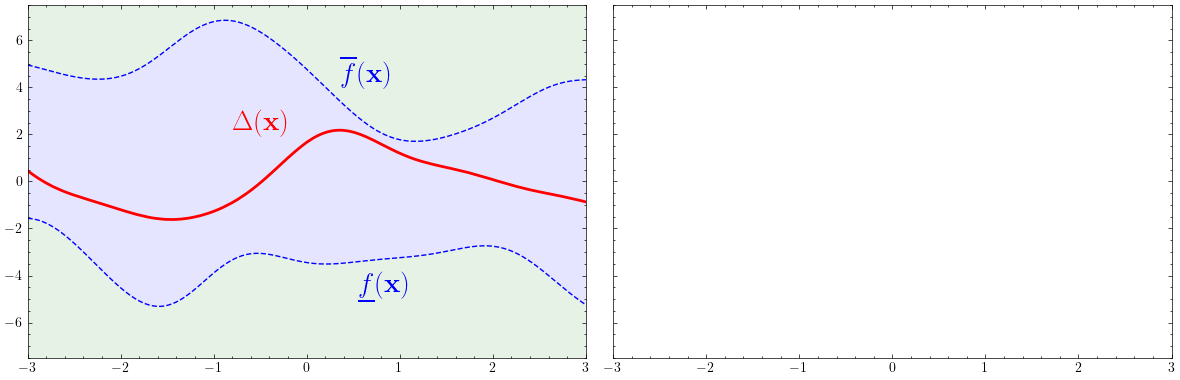

In [195]:
fig

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_6654/1406987893.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(X_plot, Y_true_CATE_GAP, 'k-', linewidth=2.0,color="r")


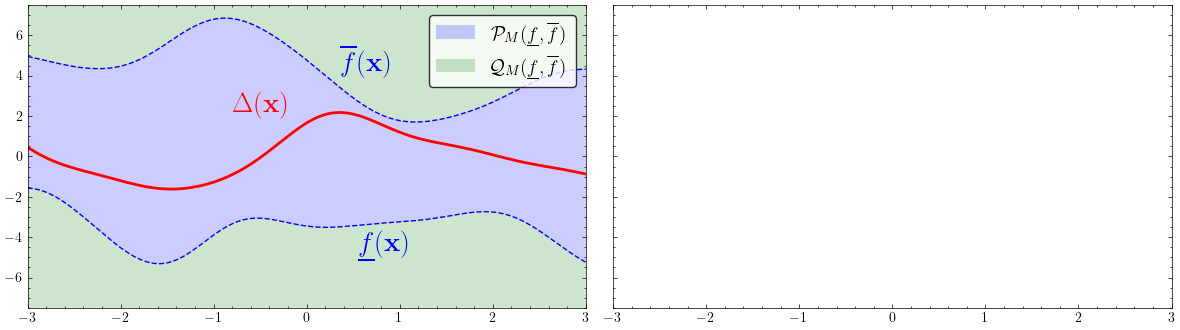

In [288]:
FIGSIZE = (12,3.5)
fig, axs = plt.subplots(ncols=2,sharex=True,figsize=FIGSIZE,sharey=True)
axs[0].set_ylim(-7.5,7.5)
axs[0].set_xlim(-3,3)
fig.tight_layout()

X_plot = torch.linspace(-3, 3, 1000).unsqueeze(1)

CATE_MAIN_func = return_CATE_GAP(outcome_funcs_GP)

CATE_top_func = return_CATE_GAP(CATE_top_func_GP)

CATE_bottom_func = return_CATE_GAP(CATE_bottom_func_GP)

Y_true_CATE_GAP = CATE_MAIN_func(X_plot)

Y_top_func = CATE_top_func(X_plot) + 4

Y_bottom_func = CATE_bottom_func(X_plot) - 4

axs[0].plot(X_plot, Y_true_CATE_GAP, 'k-', linewidth=2.0,color="r")

axs[0].plot(X_plot, Y_top_func, '--',linewidth=1.0,color="b")

axs[0].plot(X_plot, Y_bottom_func, '--',linewidth=1.0,color="b")

X_plot = torch.linspace(-3, 3, 1000)

axs[0].fill_between(X_plot,
            y1=Y_bottom_func,y2=Y_top_func,
            alpha=.2, fc='b', ec='None', label= r'$\mathcal{P}_{M}(\underline{f},\overline{f})$')

axs[0].fill_between(X_plot,
            y1=Y_top_func,y2=7.5*torch.ones_like(Y_top_func),
            alpha=.2, fc='g', ec='None', label= r'$\mathcal{Q}_{M}(\underline{f},\overline{f})$')

axs[0].fill_between(X_plot,
            y1=Y_bottom_func,y2=-7.5*torch.ones_like(Y_top_func),
            alpha=.2, fc='g', ec='None')

axs[0].annotate(r'$\overline{f}(\mathbf{x})$', xy=(X_plot[500]+0.35,Y_top_func[500]-0.55), fontsize=20,color="b")

axs[0].annotate(r'$\Delta(\mathbf{x})$', xy=(X_plot[500]-0.8,Y_true_CATE_GAP[500]+0.5), fontsize=20,color="r")

axs[0].annotate(r'$\underline{f}(\mathbf{x})$', xy=(X_plot[500]+0.55,Y_bottom_func[500]-1.25), fontsize=20,color="b")

legend = axs[0].legend(frameon = 1,prop={'size': 14},loc = "upper right")
frame = legend.get_frame()

frame.set_facecolor('white')
frame.set_edgecolor('black')

In [182]:
def triangle_func(x,base_points,peak_point):
    mid_point = 0.5*(base_points[0]+base_points[1])
    Y_plot = (x<mid_point).float() *( peak_point*(x-base_points[0])/(mid_point-base_points[0])) + (x>mid_point).float() *(peak_point*(base_points[1]-x)/(base_points[1]-mid_point) )
    Y_plot = torch.logical_and((x>base_points[0]),(x<base_points[1])).float() * Y_plot
    if len(Y_plot.shape)>1:
        Y_plot = Y_plot.squeeze(1)
    return Y_plot

In [236]:
base_points = [(-1.15,-0.85),(0.15,0.4),(1.7,1.9)]
peak_points = [-6,3,5]

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_6654/1829928705.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[1].plot(X_plot[truth_vec], Y_true_CATE_GAP[truth_vec], 'k-', label=r'$\Delta(\mathbf{x})$',linewidth=2.0,color="r")
/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_6654/1829928705.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[1].plot(X_plot[truth_vec], Y_true_CATE_GAP[truth_vec], 'k-', label=r'$\Delta(\mathbf{x})$',linewidth=2.0,color="r")


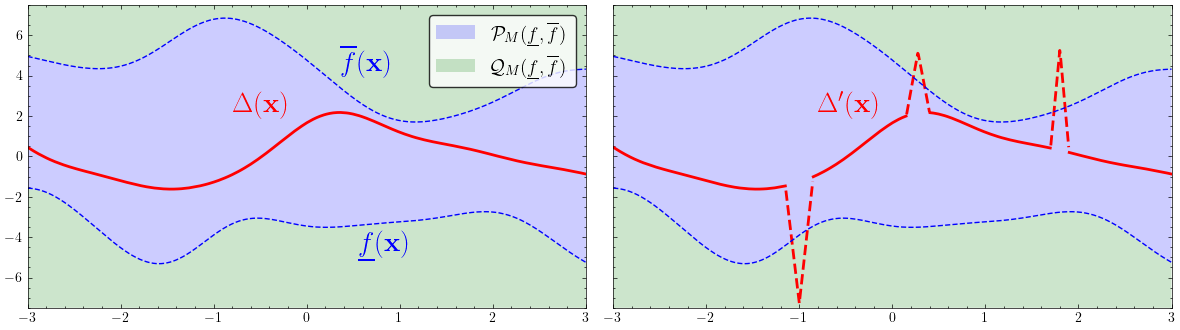

In [289]:
axs[1].set_ylim(-7.5,7.5)
axs[1].set_xlim(-3,3)
# fig.tight_layout()

X_plot = torch.linspace(-3, 3, 1000)

begin_point = -3

for base_point,peak in zip(base_points,peak_points):
    truth_vec = torch.logical_and((X_plot>begin_point),(X_plot<base_point[0]))
    axs[1].plot(X_plot[truth_vec], Y_true_CATE_GAP[truth_vec], 'k-', label=r'$\Delta(\mathbf{x})$',linewidth=2.0,color="r")

    truth_vec_2 = torch.logical_and((X_plot>base_point[0]),(X_plot<base_point[1]))

    axs[1].plot(X_plot[truth_vec_2], Y_true_CATE_GAP[truth_vec_2]+ triangle_func(X_plot[truth_vec_2],base_point,peak), '--', label=r'$\Delta(\mathbf{x})$',linewidth=2.0,color="r")

    begin_point = base_point[1]

truth_vec = torch.logical_and((X_plot>begin_point),(X_plot<3))
axs[1].plot(X_plot[truth_vec], Y_true_CATE_GAP[truth_vec], 'k-', label=r'$\Delta(\mathbf{x})$',linewidth=2.0,color="r")


axs[1].plot(X_plot, Y_top_func, '--', label=r'$b(\mathbf{x})$',linewidth=1.0,color="b")

axs[1].plot(X_plot, Y_bottom_func, '--', label=r'$a(\mathbf{x})$',linewidth=1.0,color="b")

axs[1].fill_between(X_plot,
            y1=Y_bottom_func,y2=Y_top_func,
            alpha=.2, fc='b', ec='None', label= r'{Q}_{M}')

axs[1].fill_between(X_plot,
            y1=Y_top_func,y2=7.5*torch.ones_like(Y_top_func),
            alpha=.2, fc='g', ec='None', label= r'{Q}_{M}')

axs[1].fill_between(X_plot,
            y1=Y_bottom_func,y2=-7.5*torch.ones_like(Y_top_func),
            alpha=.2, fc='g', ec='None', label= r'{Q}_{M}')

# axs[1].annotate(r'$\overline{f}(\mathbf{x})$', xy=(X_plot[500]+0.35,Y_top_func[500]-0.55), fontsize=20,color="b")

axs[1].annotate(r'$\Delta^{\prime}(\mathbf{x})$', xy=(X_plot[500]-0.8,Y_true_CATE_GAP[500]+0.5), fontsize=20,color="r")

# axs[1].annotate(r'$\underline{f}(\mathbf{x})$', xy=(X_plot[500]+0.55,Y_bottom_func[500]-1.25), fontsize=20,color="b")
fig

In [290]:
axs[0].set_title("a) Illustrating the Sets of Distributions",y=-0.15,fontsize = 20)
axs[1].set_title("b) Illustrating the Proof",y=-0.15,fontsize = 20)

Text(0.5, -0.15, 'b) Illustrating the Proof')

In [299]:
fig.suptitle("Illustration Demonstrating the Technical Results",fontsize = 20,y=1.05)

Text(0.5, 1.05, 'Illustration Demonstrating the Technical Results')

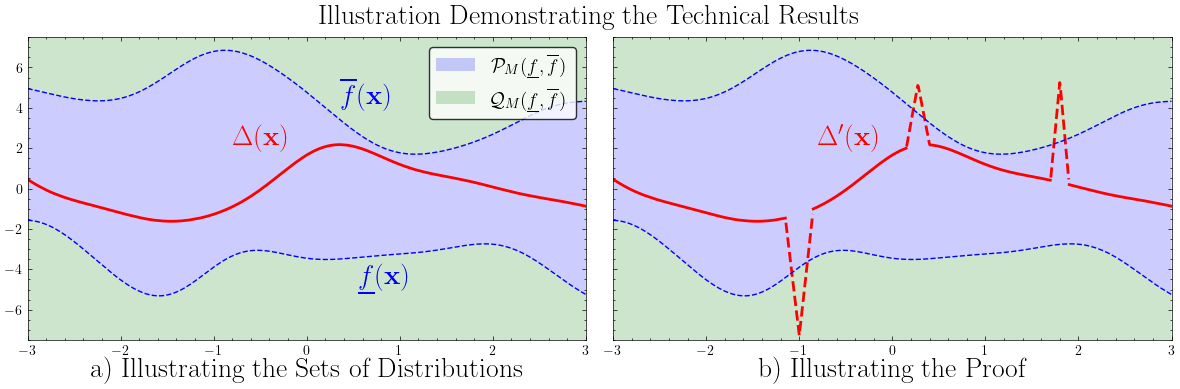

In [300]:
fig

In [297]:
X_eval = torch.linspace(-3,3,5000).unsqueeze(1)

Y_true_CATE_GAP = CATE_MAIN_func(X_eval)

Y_top_func = CATE_top_func(X_eval) + 4

Y_bottom_func = CATE_bottom_func(X_eval) - 4

In [298]:
torch.save(Y_true_CATE_GAP,"Y_true_CATE_GAP_plot.pt")
torch.save(Y_top_func,"Y_top_func_plot.pt")
torch.save(Y_bottom_func,"Y_bottom_func_plot.pt")

In [16]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = FixedPseudoOutcome_MultitaskGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop,Train=False)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward(retain_graph=True)
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()
    # # loss.zero_grad()


model.eval()
likelihood.eval()

/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1724788636145/work/torch/csrc/utils/tensor_new.cpp:643.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


Iter 1/50 - Loss: 1.476
Iter 2/50 - Loss: 1.462
Iter 3/50 - Loss: 1.455
Iter 4/50 - Loss: 1.456
Iter 5/50 - Loss: 1.441
Iter 6/50 - Loss: 1.439
Iter 7/50 - Loss: 1.446
Iter 8/50 - Loss: 1.448
Iter 9/50 - Loss: 1.440
Iter 10/50 - Loss: 1.449
Iter 11/50 - Loss: 1.448
Iter 12/50 - Loss: 1.446
Iter 13/50 - Loss: 1.451
Iter 14/50 - Loss: 1.446
Iter 15/50 - Loss: 1.450
Iter 16/50 - Loss: 1.450
Iter 17/50 - Loss: 1.446
Iter 18/50 - Loss: 1.448
Iter 19/50 - Loss: 1.441
Iter 20/50 - Loss: 1.437
Iter 21/50 - Loss: 1.449
Iter 22/50 - Loss: 1.443
Iter 23/50 - Loss: 1.444
Iter 24/50 - Loss: 1.443
Iter 25/50 - Loss: 1.444
Iter 26/50 - Loss: 1.442
Iter 27/50 - Loss: 1.435
Iter 28/50 - Loss: 1.445
Iter 29/50 - Loss: 1.443
Iter 30/50 - Loss: 1.440
Iter 31/50 - Loss: 1.439
Iter 32/50 - Loss: 1.444
Iter 33/50 - Loss: 1.447
Iter 34/50 - Loss: 1.441
Iter 35/50 - Loss: 1.440
Iter 36/50 - Loss: 1.440
Iter 37/50 - Loss: 1.444
Iter 38/50 - Loss: 1.447
Iter 39/50 - Loss: 1.444
Iter 40/50 - Loss: 1.449
Iter 41/5

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [17]:
X_plot = torch.linspace(-3, 3, 1000).unsqueeze(1)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()
X_plot = torch.linspace(-3, 3, 1000)

/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_28276/697062000.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[0].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")


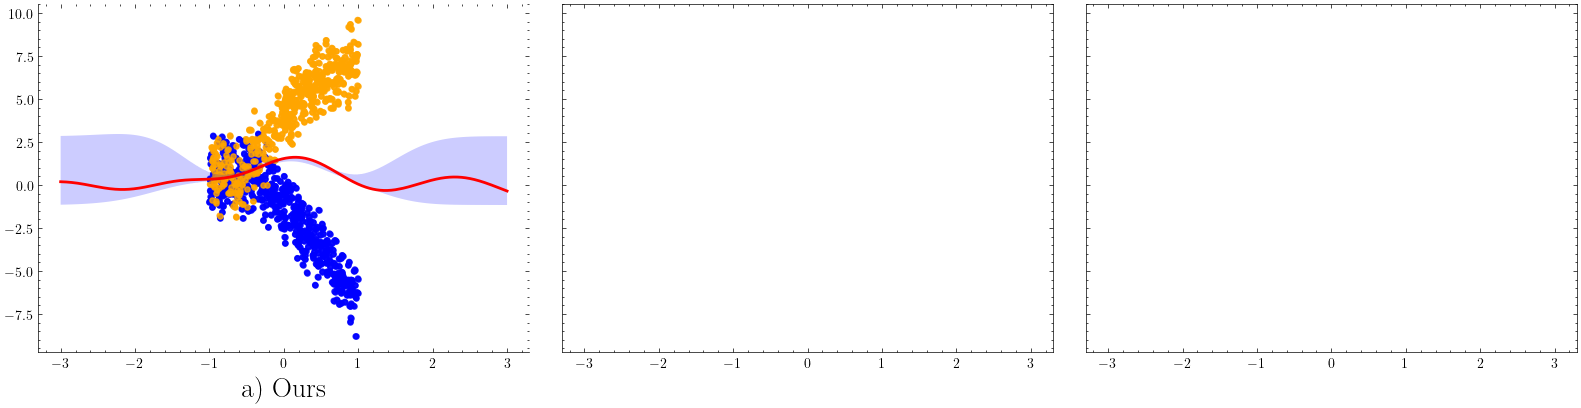

In [19]:

fig.tight_layout()
axs[0].set_axisbelow(True)
axs[0].set_title("a) Ours",y=-0.15,fontsize = 20)
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
colors = ["blue","orange"]

scatter = axs[0].scatter(pseudo_data_adjusted.X,pseudo_data_adjusted.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()],s=14,alpha=0.8)

axs[0].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")

for t in range(2):
    pseudo_data_conditioned = get_conditioned_data(pseudo_data_adjusted,T_val=t)
    axs[0].scatter(pseudo_data_conditioned.X,pseudo_data_conditioned.Y,c=colors[t],label = r'$T={T}$'.format(T=t),s=14,alpha=0.8)


axs[0].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= '95\% CI')

In [20]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = PseudoOutcome_StandardGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 11.111
Iter 2/50 - Loss: 10.430
Iter 3/50 - Loss: 9.814
Iter 4/50 - Loss: 9.261
Iter 5/50 - Loss: 8.762
Iter 6/50 - Loss: 8.312
Iter 7/50 - Loss: 7.903
Iter 8/50 - Loss: 7.538
Iter 9/50 - Loss: 7.211
Iter 10/50 - Loss: 6.911
Iter 11/50 - Loss: 6.643
Iter 12/50 - Loss: 6.393
Iter 13/50 - Loss: 6.172
Iter 14/50 - Loss: 5.969
Iter 15/50 - Loss: 5.792
Iter 16/50 - Loss: 5.628
Iter 17/50 - Loss: 5.484
Iter 18/50 - Loss: 5.345
Iter 19/50 - Loss: 5.218
Iter 20/50 - Loss: 5.105
Iter 21/50 - Loss: 4.997
Iter 22/50 - Loss: 4.902
Iter 23/50 - Loss: 4.810
Iter 24/50 - Loss: 4.725
Iter 25/50 - Loss: 4.650
Iter 26/50 - Loss: 4.585
Iter 27/50 - Loss: 4.510
Iter 28/50 - Loss: 4.459
Iter 29/50 - Loss: 4.409
Iter 30/50 - Loss: 4.346
Iter 31/50 - Loss: 4.299
Iter 32/50 - Loss: 4.260
Iter 33/50 - Loss: 4.213
Iter 34/50 - Loss: 4.175
Iter 35/50 - Loss: 4.136
Iter 36/50 - Loss: 4.099
Iter 37/50 - Loss: 4.071
Iter 38/50 - Loss: 4.039
Iter 39/50 - Loss: 4.001
Iter 40/50 - Loss: 3.970
Iter 41

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [21]:
model.covar_module.lengthscale

tensor([[3.4380e-05]], grad_fn=<SoftplusBackward0>)

In [22]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 12.334993362426758
Parameter name: mean_module.raw_constant                   value = 1.0318970680236816
Parameter name: covar_module.raw_lengthscale               value = -10.278014183044434


In [23]:
X_plot = torch.linspace(-3, 3, 1000).unsqueeze(1)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()
X_plot = torch.linspace(-3, 3, 1000)

axs[1].set_axisbelow(True)
axs[1].set_title("b) Standard Pseudo Outcome GP",y=-0.15,fontsize = 20)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
colors = ["blue","orange"]

for t in range(2):
    pseudo_data_conditioned = get_conditioned_data(pseudo_data_adjusted,T_val=t)
    axs[1].scatter(pseudo_data_conditioned.X,pseudo_data_conditioned.Y,c=colors[t],label = r'$T={T}$'.format(T=t),s=14,alpha=0.8)

axs[1].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")

axs[1].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= '95% Credible Interval')


/var/folders/v1/x4lr48v53397r9xsq4q70mvw0000gn/T/ipykernel_28276/4254664569.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  axs[1].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$\tau(x)$',linewidth=2.0,color="r")


In [24]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = TrainedPseudoOutcome_MultitaskGPModel((pseudo_data_adjusted.X, pseudo_data_adjusted.T), pseudo_data_adjusted.Y, likelihood,p_score=T_prop)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(pseudo_data_adjusted.X, pseudo_data_adjusted.T)
    loss = -mll(output, pseudo_data_adjusted.Y)
    loss.backward()
    print('Iter %d/50 - Loss: %.3f' % (i + 1, loss.item()))
    optimizer.step()

model.eval()
likelihood.eval()

Iter 1/50 - Loss: 1.502
Iter 2/50 - Loss: 1.484
Iter 3/50 - Loss: 1.469
Iter 4/50 - Loss: 1.458
Iter 5/50 - Loss: 1.452
Iter 6/50 - Loss: 1.457
Iter 7/50 - Loss: 1.444
Iter 8/50 - Loss: 1.456
Iter 9/50 - Loss: 1.444
Iter 10/50 - Loss: 1.450
Iter 11/50 - Loss: 1.452
Iter 12/50 - Loss: 1.445
Iter 13/50 - Loss: 1.442
Iter 14/50 - Loss: 1.447
Iter 15/50 - Loss: 1.453
Iter 16/50 - Loss: 1.448
Iter 17/50 - Loss: 1.440
Iter 18/50 - Loss: 1.446
Iter 19/50 - Loss: 1.435
Iter 20/50 - Loss: 1.438
Iter 21/50 - Loss: 1.447
Iter 22/50 - Loss: 1.438
Iter 23/50 - Loss: 1.439
Iter 24/50 - Loss: 1.439
Iter 25/50 - Loss: 1.440
Iter 26/50 - Loss: 1.443
Iter 27/50 - Loss: 1.444
Iter 28/50 - Loss: 1.441
Iter 29/50 - Loss: 1.440
Iter 30/50 - Loss: 1.444
Iter 31/50 - Loss: 1.443
Iter 32/50 - Loss: 1.443
Iter 33/50 - Loss: 1.444
Iter 34/50 - Loss: 1.452
Iter 35/50 - Loss: 1.440
Iter 36/50 - Loss: 1.443
Iter 37/50 - Loss: 1.446
Iter 38/50 - Loss: 1.435
Iter 39/50 - Loss: 1.439
Iter 40/50 - Loss: 1.448
Iter 41/5

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [25]:
self = model
x = X_plot

In [37]:
t0 = torch.full((x.shape[0],1), dtype=torch.long, fill_value=0)
t1 = torch.full((x.shape[0],1), dtype=torch.long, fill_value=1)

n = x.shape[0]

guas_cross = self(torch.cat([x,x]) ,torch.cat([t1,t0]))
CATE_mean = self.p_score*guas_cross.mean[:n] + (1-self.p_score)*guas_cross.mean[n:]
CATE_covar = (self.p_score**2)*torch.diag(guas_cross.variance[:n]) + (1-self.p_score)**2*torch.diag(guas_cross.variance[n:]) + (1-self.p_score)*self.p_score*(guas_cross.covariance_matrix[:n,n:] + guas_cross.covariance_matrix[n:,:n])
CATE_covar = CATE_covar.diag()
CATE_covar[CATE_covar<1e-06] = 1e-06
CATE_covar = torch.diag(CATE_covar)

In [38]:
gpytorch.distributions.MultivariateNormal(CATE_mean, CATE_covar)

MultivariateNormal(loc: torch.Size([1000]), covariance_matrix: torch.Size([1000, 1000]))

In [27]:
CATE_covar.min()

tensor(0., grad_fn=<MinBackward1>)

In [28]:
guas_cross.covariance_matrix[:n,:n].diag().min()

tensor(0.0047, grad_fn=<MinBackward1>)

In [29]:
guas_cross.covariance_matrix[n:,n:].diag().max()

tensor(12.0723, grad_fn=<MaxBackward1>)

In [30]:
(guas_cross.covariance_matrix[:n,n:] + guas_cross.covariance_matrix[n:,:n]).diag().min()

tensor(-22.0633, grad_fn=<MinBackward1>)

In [31]:
guas_cross.variance.min()

tensor(0.0040, grad_fn=<MinBackward1>)

In [32]:
guas_cross.covariance_matrix[:n,:n].diag().min()

tensor(0.0047, grad_fn=<MinBackward1>)

In [33]:
CATE_covar.diag().min()

tensor(0.0027, grad_fn=<MinBackward1>)

In [34]:
X_plot = torch.linspace(-3, 3, 1000).unsqueeze(1)

CATE_GAP_func = return_CATE_GAP(outcome_funcs_GP)

Y_true_CATE_GAP = CATE_GAP_func(X_plot)
CATE_pred_guas = model.CATE(X_plot)
region_lower,region_upper = CATE_pred_guas.confidence_region()
X_plot = torch.linspace(-3, 3, 1000)

axs[2].set_axisbelow(True)
axs[2].set_title("c) LCM Multi-Task GP",y=-0.15,fontsize = 20)
axs[2].spines['right'].set_visible(False)
axs[2].spines['top'].set_visible(False)
colors = ["blue","orange"]

axs[2].scatter(pseudo_data_adjusted.X,pseudo_data_adjusted.Y,c=[colors[i] for i  in pseudo_data.T.int().tolist()],s=14,alpha=0.8)

axs[2].plot(X_plot, Y_true_CATE_GAP, 'k-', label=r'$f(x)$',linewidth=2.0,color="r")

axs[2].fill_between(X_plot.detach(),
            y1=region_lower.detach(),y2=region_upper.detach(),
            alpha=.2, fc='b', ec='None', label= 'Our approach')

ValueError: covariance_matrix must be at least two-dimensional, with optional leading batch dimensions

In [ ]:
fig.suptitle("Bayesian Credible Intervals for CATE across GP based pseudo-outcome regressors",fontsize = 20,y=1.05)

Text(0.5, 1.05, 'Bayesian Credible Intervals for CATE across GP based pseudo-outcome regressors')

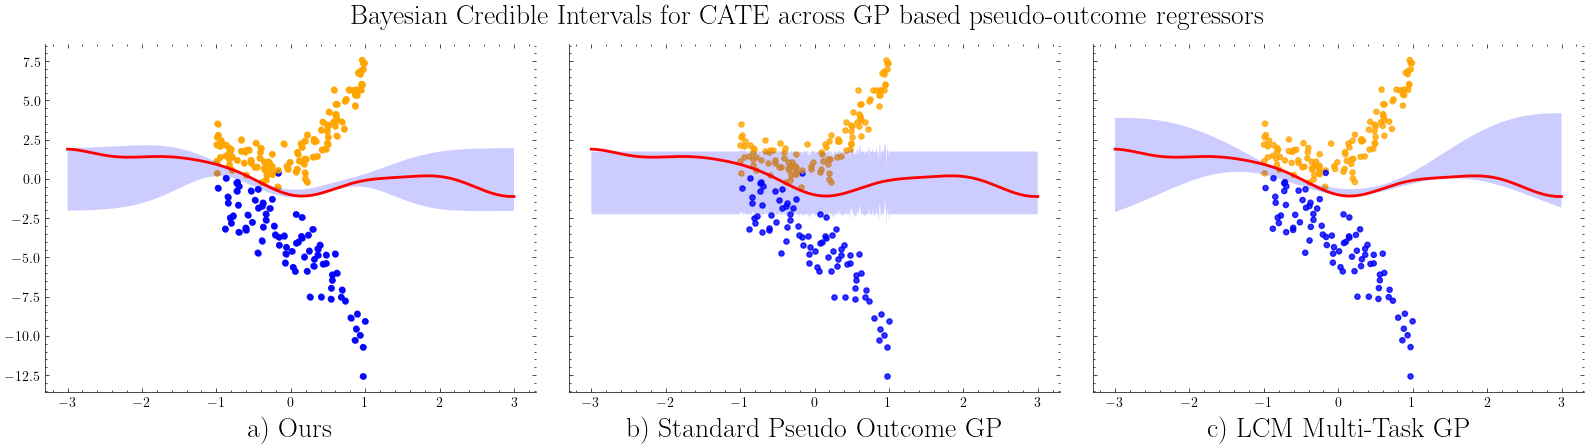

In [ ]:
fig

In [ ]:
handles, labels = axs[0].get_legend_handles_labels()
labels[3],labels[1] = labels[1],labels[3]
handles[1],handles[3] = handles[3],handles[1]
# legend1 = axs[0].legend(*scatter.legend_elements(),
#                     loc="lower left", title="Classes")
# reverse the order
legend2 =axs[0].legend(handles, labels,ncols=2,loc="upper left")
# axs[0].legend()

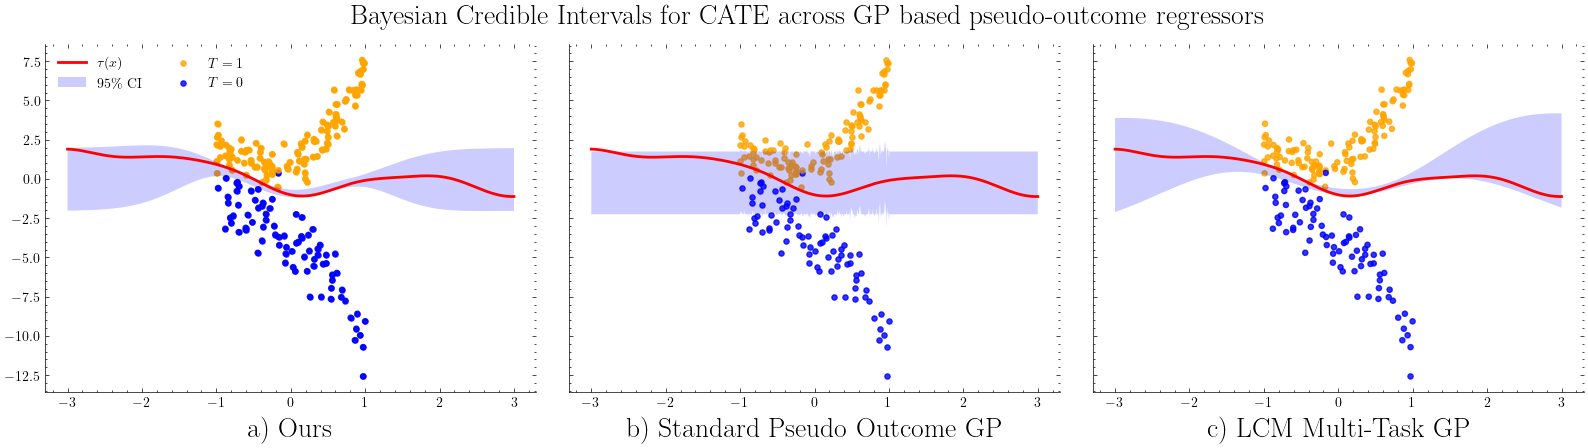

In [ ]:
fig

In [ ]:
d = 5
X_d = torch.rand(n_samples_obs,d)

In [ ]:
get_gp_samples(X_d,dimx=d,train_data=None,likelihood=None)

tensor([ 7.0638e-02, -1.0820e+00,  7.5575e-01, -6.5676e-01, -6.2520e-01,
         2.5928e-01,  1.8811e-01, -2.9875e-01, -2.8262e-01, -3.8895e-01,
        -3.0830e-01, -2.8833e-01,  7.6373e-01,  6.6265e-01,  1.4787e-01,
         2.5584e-01, -6.6008e-01, -5.7270e-01,  1.5675e-01,  1.9574e-01,
        -4.8841e-01, -8.5211e-01, -5.2974e-01,  4.5305e-01,  2.5178e-01,
        -1.4276e+00,  9.7498e-01, -6.0782e-01, -4.2841e-01,  7.8705e-01,
        -3.9161e-02, -9.1059e-01, -2.6893e-01,  2.9255e-01,  4.2552e-03,
        -1.9649e-01,  2.0254e-01,  1.4108e+00, -4.7503e-01, -3.3711e-01,
         7.1273e-01,  6.4759e-01, -6.2665e-01, -3.7441e-01,  4.6162e-01,
        -6.2784e-01, -7.5358e-01,  6.1429e-02, -5.3451e-01,  8.3182e-01,
        -5.8703e-01, -1.1225e+00,  1.6939e-01, -1.1565e+00, -3.7467e-01,
        -1.2916e+00,  5.4534e-01, -3.6052e-02,  6.8169e-02, -3.4780e-01,
        -4.8956e-01, -2.3373e-01,  1.3097e-01, -4.2022e-01,  1.0050e-01,
        -2.1739e-01, -4.0716e-01,  3.6096e-01,  7.8

In [ ]:
rff_kern = gpytorch.kernels.RFFKernel(num_samples=100)

In [ ]:
def sample_rff(x,dimx,num_samples_RFF=100,
    lengthscale=1,
    coefficient= 1):
    
    # Dimension of data space
    omega_shape = (1, num_samples_RFF, dimx)
    
    # Handle each of three possible kernels separately
    
    omega = torch.randn(size=omega_shape)
        
        
    # Scale omegas by lengthscale
    omega = omega / lengthscale
    
    weights = torch.randn(size=(1, num_samples_RFF))
    phi = torch.FloatTensor(1, num_samples_RFF).uniform_(0, (2 * torch.pi))

    
    features = torch.cos(torch.einsum('sfd, nd -> sfn', omega, x) + phi)
    features = (2 / num_samples_RFF) ** 0.5 * features * coefficient
    
    functions = torch.einsum('sf, sfn -> sn', weights, features)
    
    return functions, features

In [ ]:
X_eva

NameError: name 'X_eva' is not defined

In [ ]:
sample_rff(X_eval,2,num_samples_RFF=100,
    lengthscale=1,
    coefficient= 1)

RuntimeError: einsum(): the number of subscripts in the equation (2) does not match the number of dimensions (3) for operand 1 and no ellipsis was given

In [ ]:
def GP_func(X_range,
               d=1,N_eval_points=5000,train_data=None,likelihood=None,scale=1,kernel="RBF",num_samples_RFF=100):
    if d==1: 
        X_eval = torch.linspace(X_range[0],X_range[1],steps=N_eval_points)
        Y_eval = get_gp_samples(X_eval,train_data=train_data,likelihood=likelihood,kernel=kernel,num_samples_RFF=num_samples_RFF)
        def GP(X):
            a = ((N_eval_points-1)*(X-X_range[0])/(X_range[1]-X_range[0])).int()
            return scale*Y_eval[a]
        return GP    

In [ ]:
def RFF_GP(dimx,num_samples):
    rff_kern = gpytorch.kernels.RFFKernel(num_samples=num_samples,num_dims=dimx)
    weights = torch.randn(2*num_samples)
    def GP(X):
        z = rff_kern._featurize(x=X_d,normalize=True)
        return z @ weights
    return GP

In [ ]:
X_d.shape

torch.Size([1000, 5])

In [ ]:
dimx = 5
num_samples = 100

In [ ]:
weights = torch.randn(2*num_samples)

In [ ]:
z = rff_kern._featurize(x=X_d,normalize=True)

In [ ]:
(z @ weights)

tensor([ 1.8833,  2.1217,  1.4736,  1.5713,  0.5998,  0.8289,  0.4788,  0.8577,
         0.8728,  1.4274,  1.1200,  1.0823,  1.3883,  2.3396,  0.8386,  1.9225,
         1.6207,  2.3544,  2.1576,  1.4351,  0.6983,  1.4843,  1.1488,  1.1769,
         1.6417,  1.3157,  0.9408,  1.6932,  2.0161,  1.0237,  0.9174,  1.5165,
         1.3030,  1.7305,  2.2141,  2.2182,  1.5717,  0.4577,  1.6798,  2.2400,
         1.3030,  1.3401,  0.7412,  1.5277,  1.9158,  1.6104,  2.1167,  1.7578,
         0.0267,  0.2912,  0.4249,  1.5875,  1.0043,  2.4383,  1.3633,  1.9510,
         1.4839,  1.8627,  0.7840,  0.3647,  1.2609,  1.5850,  1.6386,  1.4734,
         0.1185,  1.5905,  1.5848,  2.2010,  1.9117,  0.5502,  1.5121,  1.2869,
         2.3302,  1.7301,  1.2422,  1.6449,  2.3069,  0.7901,  1.0974,  1.3293,
         1.8368,  2.2905,  1.2764, -0.0055,  0.9593,  1.3937,  1.8870,  0.0958,
         0.6922,  0.2329,  0.5374,  1.8203,  1.2926,  0.2840,  1.8633,  0.5164,
         1.6708,  1.5181,  1.4221,  1.38

In [ ]:
rff_kern = gpytorch.kernels.RFFKernel(num_samples=100,num_dims=5)

In [ ]:
rff_kern.randn_weights

tensor([[-7.0944e-01, -2.7429e-01, -3.5819e-01,  4.2447e-01,  7.5103e-01,
         -8.1881e-01,  7.7175e-01,  1.5018e+00,  4.4129e-01,  3.3600e-01,
         -4.3551e-01, -2.7025e-01,  5.5268e-01, -4.3179e-01, -4.1628e-01,
          1.2341e+00, -1.1588e+00,  1.1538e+00, -9.9942e-01,  4.9427e-01,
         -1.5020e-01, -9.9993e-01,  2.6442e-01, -6.2833e-01,  7.8621e-02,
          1.6321e+00,  3.9233e-02,  1.5751e+00, -2.1053e+00, -4.1446e-01,
         -1.8436e+00,  8.5083e-01, -2.3707e-01, -9.7306e-01,  4.1849e-01,
          8.4847e-01,  4.4733e-01,  7.2285e-01,  4.3061e-01,  4.8366e-01,
         -9.3169e-01,  1.2068e-01, -1.3554e+00,  7.7871e-01, -6.9105e-01,
          1.4870e+00, -7.5332e-01,  8.2339e-01, -1.9517e+00, -8.6403e-01,
          2.9385e-01, -3.9116e-01, -1.0327e+00, -4.5827e-01,  1.4590e+00,
         -4.2948e-01,  4.3347e-01,  7.8279e-01,  9.9180e-01,  2.3974e-01,
         -1.4536e+00, -1.6018e+00,  2.1695e-01,  5.5575e-01, -7.5810e-01,
          1.0024e+00, -7.4308e-01, -2.

tensor([[ 0.8823,  0.9995,  0.5702,  ...,  0.8293, -0.1048, -0.6455],
        [ 0.9987,  0.9639,  0.8817,  ...,  0.7939, -0.1016, -0.9940],
        [ 0.2280,  0.8070,  0.0270,  ...,  0.1621,  0.8739,  0.9435],
        ...,
        [ 0.6940,  0.9575, -0.5922,  ...,  0.5194,  0.6910,  0.8278],
        [ 0.8500,  0.9587,  0.3438,  ...,  0.7805,  0.4111, -0.8652],
        [ 0.8905,  0.7230,  0.1789,  ...,  0.7824,  0.8146, -1.0000]],
       grad_fn=<CatBackward0>)

In [ ]:
torch.FloatTensor(10, 10).uniform_(0, 10)

tensor([[2.8582, 4.9364, 7.4408, 5.1592, 9.7929, 0.5546, 3.4376, 3.7624, 4.6668,
         6.2100],
        [4.9619, 2.1273, 5.0964, 6.9147, 5.7123, 8.6324, 8.8892, 0.1648, 5.7329,
         4.6089],
        [9.1952, 2.9297, 5.4387, 1.2132, 2.5941, 5.2260, 2.9472, 6.7427, 5.1850,
         1.4823],
        [8.3799, 1.3255, 6.1506, 6.2782, 2.0168, 2.7216, 2.5520, 6.7425, 4.4122,
         9.0572],
        [7.6275, 4.0959, 8.0713, 6.7428, 0.7687, 8.9614, 1.0005, 0.9290, 4.0364,
         2.7566],
        [8.4886, 3.1996, 6.0171, 8.7848, 0.2905, 3.7367, 4.2361, 1.7486, 5.1334,
         3.3301],
        [4.3847, 7.5017, 8.1152, 4.1647, 9.6068, 8.9067, 4.7099, 2.2874, 3.8008,
         6.8985],
        [2.6113, 0.9919, 6.9231, 9.6363, 0.9814, 0.4806, 8.6072, 3.0395, 4.0123,
         2.7946],
        [1.0384, 6.0215, 8.3417, 3.4070, 6.9414, 2.8363, 6.5127, 0.3669, 5.8251,
         0.5035],
        [2.6367, 6.1559, 9.4365, 4.9676, 2.7741, 3.9813, 9.9888, 5.7911, 9.2342,
         5.3412]])

In [ ]:
torch.rand

In [ ]:
X_range = (-1,1)
d=2
N_eval_points=1
train_data=None
likelihood=None
scale=1

In [ ]:
start_range = [X_range[0]]*d
end_range = [X_range[1]]*d
X_eval = multidim_linspace(start_range, end_range, N_eval_points)

In [ ]:
Y_eval = get_gp_samples(X_eval.reshape(d,-1).T,dimx=d,kernel="RFF",num_samples_RFF=20)

tensor([-0.6815, -0.6497, -0.6178,  ..., -0.3470, -0.3634, -0.3772])

In [ ]:
X_eval = torch.linspace(X_range[0],X_range[1],steps=N_eval_points)
Y_eval = get_gp_samples(X_eval,train_data=train_data,likelihood=likelihood)
def GP(X):
    a = ((N_eval_points-1)*(X-X_range[0])/(X_range[1]-X_range[0])).int()
    return scale*Y_eval[a]

/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/jake/Python/Obs_and_exp_data/.conda/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(


In [ ]:
kern = gpytorch.kernels.RFFKernel(num_samples=100,num_dims=dimx)

In [ ]:
kern.randn_weights.shape

torch.Size([1, 100])